In [11]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier
)

# Validation of the models
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    make_scorer,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

# Preprocessing and transformations
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib


In [13]:
# Import dataset
test_features = pd.read_csv("../data/processed/test_features.csv")
test_labels=pd.read_csv("../data/processed/test_labels.csv")
train_features=pd.read_csv("../data/processed/train_features.csv")
train_labels=pd.read_csv("../data/processed/train_labels.csv")

In [14]:
# Convert object variables into categorical ones for labels dataset

train_labels["income"] = pd.Categorical(train_labels["income"])
train_labels.info()

test_labels["income"] = pd.Categorical(test_labels["income"])
test_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24129 entries, 0 to 24128
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   income  24129 non-null  category
dtypes: category(1)
memory usage: 23.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6033 entries, 0 to 6032
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   income  6033 non-null   category
dtypes: category(1)
memory usage: 6.1 KB


In [15]:
# Convert object variables into categorical ones for features dataset

categorical_columns = train_features.select_dtypes(include='object').columns

for col in categorical_columns:
    train_features[col] = pd.Categorical(train_features[col])

train_features.info()

categorical_columns = test_features.select_dtypes(include='object').columns

for col in categorical_columns:
    test_features[col] = pd.Categorical(test_features[col])

test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24129 entries, 0 to 24128
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   age                     24129 non-null  int64   
 1   workclass               24129 non-null  category
 2   fnlwgt                  24129 non-null  int64   
 3   education.num           24129 non-null  int64   
 4   marital.status          24129 non-null  category
 5   occupation              24129 non-null  category
 6   relationship            24129 non-null  category
 7   race                    24129 non-null  category
 8   sex                     24129 non-null  category
 9   capital.gain            24129 non-null  int64   
 10  capital.loss            24129 non-null  int64   
 11  hours.per.week          24129 non-null  int64   
 12  native.country.grouped  24129 non-null  category
 13  education.grouped       24129 non-null  category
dtypes: category(8), int64(

In [16]:
train_labels = train_labels.squeeze()
test_labels = test_labels.squeeze()

In [17]:
# Identify categorical and numerical columns for training models
categorical_columns = train_features.select_dtypes(include=['object']).columns
numerical_columns = train_features.select_dtypes(include=['int64', 'float64']).columns

In [18]:
class CollinearityRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_remove_ = None

    def fit(self, X, y=None):
        # Correlation matrix
        corr_matrix = np.corrcoef(X, rowvar=False)
        upper_triangle = np.triu(np.abs(corr_matrix), k=1)

        # Highly correlated variables
        self.to_remove_ = np.where(upper_triangle > self.threshold)[1]
        return self

    def transform(self, X):
        # Remove correlated variables
        if self.to_remove_ is not None:
            return np.delete(X, self.to_remove_, axis=1)
        return X

numerical_columns = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
categorical_columns = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex',
                       'native.country.grouped', 'education.grouped']

# Preprocessing
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('collinearity', CollinearityRemover(threshold=0.9))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

## Logistic Regression

In [42]:
model = LogisticRegression(max_iter=1000)

# Pipeline: Preprocessing -> Feature Selection -> Model
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('var_thresh', VarianceThreshold(threshold=0.01)),  # Rimuove variabili con varianza bassa
    ('model', model)
])

param_grid_logistic = {
    'model__C': [0.01, 0.1, 1, 10, 100]
}

grid_search_logistic = GridSearchCV(
    logistic_pipeline,
    param_grid=param_grid_logistic,
    cv=10,
    scoring=make_scorer(f1_score, pos_label=1),
    verbose=1
)

grid_search_logistic.fit(train_features, train_labels)

print("Best Parameters:", grid_search_logistic.best_params_)

y_pred_logistic = grid_search_logistic.predict(test_features)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred_logistic))
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_logistic))

logistic_filename = "models/logistic_regression_model.pkl"
joblib.dump(grid_search_logistic.best_estimator_, logistic_filename)
print(f"Random Forest model saved as {logistic_filename}")


Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Parameters: {'model__C': 1}
Confusion Matrix:
[[4174  359]
 [ 601  899]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      4533
           1       0.71      0.60      0.65      1500

    accuracy                           0.84      6033
   macro avg       0.79      0.76      0.77      6033
weighted avg       0.83      0.84      0.84      6033

Random Forest model saved as models/logistic_regression_model.pkl


## KNN

In [ ]:
# KNN model
model = KNeighborsClassifier()

# Pipeline: Preprocessing -> Model
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

param_grid_knn = {
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ['uniform', 'distance'],
    'model__p': [2]
}

grid_search_knn = GridSearchCV(
    knn_pipeline,
    param_grid=param_grid_knn,
    cv=5,
    scoring=make_scorer(f1_score, pos_label=1),
    verbose=1,
    n_jobs=-1
)

grid_search_knn.fit(train_features, train_labels)

print("Best Parameters:", grid_search_knn.best_params_)

y_pred_knn = grid_search_knn.predict(test_features)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred_knn))
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_knn))

knn_filename = "models/knn_model_nuovo.pkl"
joblib.dump(grid_search_knn.best_estimator_, knn_filename)  # Salviamo il modello ottimizzato
print(f"KNN model saved as {knn_filename}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'model__n_neighbors': 7, 'model__p': 2, 'model__weights': 'uniform'}
Confusion Matrix:
[[4099  434]
 [ 604  896]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4533
           1       0.67      0.60      0.63      1500

    accuracy                           0.83      6033
   macro avg       0.77      0.75      0.76      6033
weighted avg       0.82      0.83      0.82      6033

KNN model saved as models/knn_model_nuovo.pkl


## Naive Bayes

In [30]:
numerical_pipeline_nb = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('collinearity', CollinearityRemover(threshold=0.9))
])

# Necessary for Naive Bayes
categorical_pipeline_nb = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor_nb = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline_nb, numerical_columns),
        ('cat', categorical_pipeline_nb, categorical_columns)
    ]
)

model = GaussianNB()

naive_bayes_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('var_thresh', VarianceThreshold(threshold=0.01)),
    ('model', model)
])

param_grid_nb = {
    'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

grid_search_nb = GridSearchCV(
    naive_bayes_pipeline,
    param_grid=param_grid_nb,
    cv=10,
    scoring=make_scorer(f1_score, pos_label=1),
    verbose=1
)

grid_search_nb.fit(train_features, train_labels)

print("Best Parameters:", grid_search_nb.best_params_)

y_pred_nb = grid_search_nb.predict(test_features)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred_nb))
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_nb))

model_filename = "models/naive_bayes_model.pkl"
joblib.dump(grid_search_nb.best_estimator_, model_filename)
print(f"Model saved as {model_filename}")


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Parameters: {'model__var_smoothing': 1e-06}
Confusion Matrix:
[[3294 1239]
 [ 246 1254]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      4533
           1       0.50      0.84      0.63      1500

    accuracy                           0.75      6033
   macro avg       0.72      0.78      0.72      6033
weighted avg       0.82      0.75      0.77      6033

Model saved as models/naive_bayes_model.pkl


## Bagging

In [44]:
preprocessor_bagging = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

# Base model: Decision Tree
base_model = DecisionTreeClassifier(random_state=42)

bagging_model = BaggingClassifier(
    estimator=base_model,
    random_state=42
)

# Complete Pipeline
bagging_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_bagging),
    ('model', bagging_model)
])

param_grid_bagging = {
    'model__n_estimators': [50, 100],
    'model__max_samples': [0.5, 0.75],
    'model__max_features': [0.75],
    'model__bootstrap_features': [False],
}

grid_search_bagging = GridSearchCV(
    bagging_pipeline,
    param_grid=param_grid_bagging,
    cv=5,
    scoring=make_scorer(f1_score, pos_label=1),
    verbose=1,
    n_jobs=-1
)


grid_search_bagging.fit(train_features, train_labels)

print("Best Parameters:", grid_search_bagging.best_params_)

y_pred_bagging = grid_search_bagging.predict(test_features)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred_bagging))
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_bagging))

bagging_filename = "models/bagging_model.pkl"
joblib.dump(grid_search_bagging.best_estimator_, bagging_filename)
print(f"Bagging model saved as {bagging_filename}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'model__bootstrap_features': False, 'model__max_features': 0.75, 'model__max_samples': 0.5, 'model__n_estimators': 100}
Confusion Matrix:
[[4239  294]
 [ 588  912]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4533
           1       0.76      0.61      0.67      1500

    accuracy                           0.85      6033
   macro avg       0.82      0.77      0.79      6033
weighted avg       0.85      0.85      0.85      6033

Bagging model saved as models/bagging_model.pkl


## Gradient boosting

In [45]:
preprocessor_gb = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

# Gradient Boosting
model = GradientBoostingClassifier(random_state=42)

gradient_boosting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_gb),
    ('model', model)
])

param_grid_gb = {
    'model__n_estimators': [50, 100],
    'model__learning_rate': [0.1, 0.2],
    'model__max_depth': [3, 5],
    'model__subsample': [0.8],
    'model__min_samples_split': [5, 10]
}

grid_search_gb = GridSearchCV(
    gradient_boosting_pipeline,
    param_grid=param_grid_gb,
    cv=5,
    scoring=make_scorer(f1_score, pos_label=1),
    verbose=1,
    n_jobs=-1
)

grid_search_gb.fit(train_features, train_labels)

print("Best Parameters:", grid_search_gb.best_params_)

y_pred_gb = grid_search_gb.predict(test_features)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred_gb))
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_gb))

gradient_boosting_filename = "models/gradient_boosting_model.pkl"
joblib.dump(grid_search_gb.best_estimator_, gradient_boosting_filename)
print(f"Gradient Boosting model saved as {gradient_boosting_filename}")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100, 'model__subsample': 0.8}
Confusion Matrix:
[[4224  309]
 [ 528  972]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4533
           1       0.76      0.65      0.70      1500

    accuracy                           0.86      6033
   macro avg       0.82      0.79      0.80      6033
weighted avg       0.86      0.86      0.86      6033

Gradient Boosting model saved as models/gradient_boosting_model.pkl


## Random Forest

In [46]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

model = RandomForestClassifier(random_state=42)

random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [5],
    'model__min_samples_leaf': [2],
    'model__max_features': ['sqrt']
}

grid_search_rf = GridSearchCV(
    random_forest_pipeline,
    param_grid=param_grid_rf,
    cv=5,  # Riduci da 10 a 5
    scoring=make_scorer(f1_score, pos_label=1),
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(train_features, train_labels)

print("Best Parameters:", grid_search_rf.best_params_)

y_pred_rf = grid_search_rf.predict(test_features)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred_rf))
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_rf))

random_forest_filename = "models/random_forest_model.pkl"
joblib.dump(grid_search_rf.best_estimator_, random_forest_filename)
print(f"Random Forest model saved as {random_forest_filename}")


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Confusion Matrix:
[[4267  266]
 [ 614  886]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      4533
           1       0.77      0.59      0.67      1500

    accuracy                           0.85      6033
   macro avg       0.82      0.77      0.79      6033
weighted avg       0.85      0.85      0.85      6033

Random Forest model saved as models/random_forest_model.pkl


## Stacking

In [34]:
base_estimators = [
    ('knn', knn_pipeline),
    ('naive_bayes', naive_bayes_pipeline),
    ('gradient_boosting', gradient_boosting_pipeline),
    ('random_forest', random_forest_pipeline),
    ('bagging', bagging_pipeline)
]

# Final estimator
final_model = LogisticRegression(max_iter=500)

# Stacking classifier
stacking_pipeline = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_model,
    cv=5
)

# Train the stacking model
stacking_pipeline.fit(train_features, train_labels)

# Predictions
y_pred_stacking = stacking_pipeline.predict(test_features)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(test_labels, y_pred_stacking))
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_stacking))

# Save the model
stacking_filename = "models/stacking_model.pkl"
joblib.dump(stacking_pipeline, stacking_filename)
print(f"Stacking model saved as {stacking_filename}")

Confusion Matrix:
[[4241  292]
 [ 546  954]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4533
           1       0.77      0.64      0.69      1500

    accuracy                           0.86      6033
   macro avg       0.83      0.79      0.80      6033
weighted avg       0.86      0.86      0.86      6033

Stacking model saved as models/stacking_model.pkl


## Assessing with ROC curve and Lift Curve

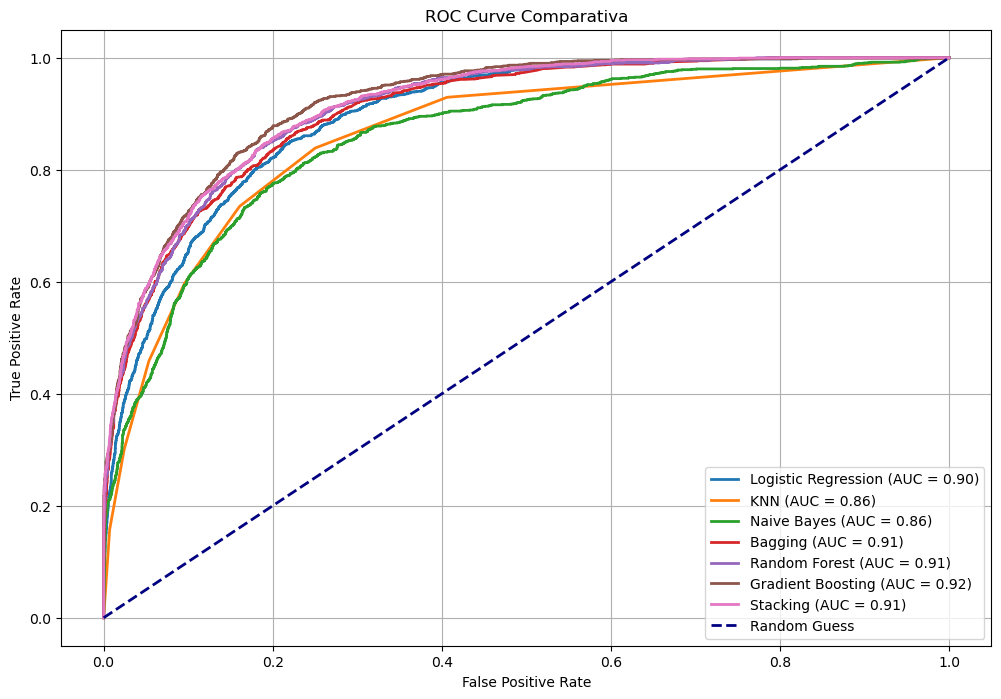

In [47]:
# Load Saved Models
models = {
    'Logistic Regression': joblib.load('models/logistic_regression_model.pkl'),
    'KNN': joblib.load('models/knn_model_nuovo.pkl'),
    'Naive Bayes': joblib.load('models/naive_bayes_model.pkl'),
    'Bagging': joblib.load('models/bagging_model.pkl'),
    'Random Forest': joblib.load('models/random_forest_model.pkl'),
    'Gradient Boosting': joblib.load('models/gradient_boosting_model.pkl'),
    'Stacking': joblib.load('models/stacking_model.pkl'),
}

model_names = []
y_probs = []

for name, model in models.items():
    try:
        if hasattr(model, 'predict_proba'):
            y_probs.append(model.predict_proba(test_features)[:, 1])
        elif hasattr(model, 'decision_function'):
            y_probs.append(model.decision_function(test_features))
        else:
            print(f"The model {name} does not support predict_proba or decision_function.")
            continue
        model_names.append(name)
    except Exception as e:
        print(f"Error in the model {name}: {e}")

def plot_roc_curve(y_true, y_probs, model_names):
    plt.figure(figsize=(12, 8))

    for y_prob, model_name in zip(y_probs, model_names):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparativa')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# ROC Curves
plot_roc_curve(test_labels, y_probs, model_names)


## Choosing the right threshold

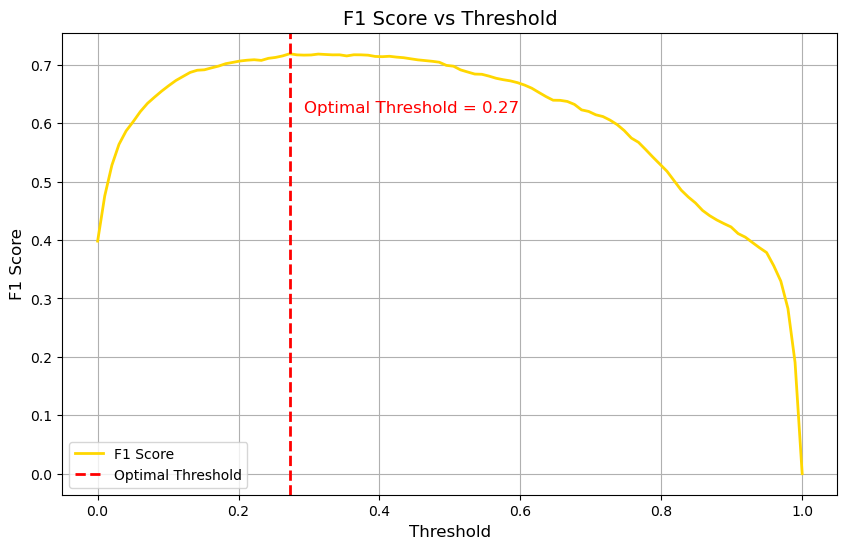

In [ ]:
y_true = test_labels
y_scores = grid_search_gb.predict_proba(test_features)[:, 1]

thresholds = np.linspace(0, 1, 100)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)
    f1_scores.append(f1_score(y_true, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='gold', linewidth=2)
plt.axvline(x=thresholds[np.argmax(f1_scores)], color='red', linestyle='--', linewidth=2, label='Optimal Threshold')
plt.text(thresholds[np.argmax(f1_scores)] + 0.02, max(f1_scores) - 0.1,
         f'Optimal Threshold = {thresholds[np.argmax(f1_scores)]:.2f}', color='red', fontsize=12)

plt.title("F1 Score vs Threshold", fontsize=14)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True)
plt.show()
